<a href="https://colab.research.google.com/github/shahriarivari/Load-Forecasting-Machine-Learing/blob/main/load_forecasting_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### installing libraries

In [34]:
# installing jdatetime for converting date to Gregotian
# !pip install scikit-learn
# !pip install matplotlib
!pip install jdatetime
!pip install scikit-optimize
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.8 MB/s eta 0:00:00


# data manipulation

inculding: 1-becoming one with data, 2-feature engieering, and 3-preprocessing

In [2]:
import pandas as pd # to import the excel file
import numpy as np  # to deal with numbers
import jdatetime    # to convert Jalali datatime to Gregorian

In [19]:
## importing data
data_df = pd.read_excel("consumption.xlsx")
temp_df = pd.read_csv("temperature.csv")

In [20]:
# Apply the conversion directly using a lambda function
data_df['date'] = data_df['date'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
data_df.rename(columns={"date": "time"}, inplace=True)

In [23]:
# making the dataframe into a column vector of time and values
# we make to lists of hours and their repective values and then concatenate them
time_hourly = []
values_hourly = []
list_of_hours = [int(col) for col in data_df.columns[1:]]
for i in range(len(data_df["time"])):
    time = pd.to_datetime(data_df['time'][i], format='%Y-%m-%d') + pd.to_timedelta(list_of_hours, unit='h').values
    values = data_df.loc[i][1:].values
    time_hourly.append(time)
    values_hourly.append(values)

In [24]:
time_concatenated = np.concatenate(time_hourly)
values_concatenated = np.concatenate(values_hourly)

In [25]:
# and now we make the new df
new_df = pd.DataFrame({"time": time_concatenated, "values": values_concatenated})
temp_df["time"] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d')
# new_df.index = pd.to_datetime(new_df['time'], format='%d.%m.%Y %H:%M:%S')
# new_df.drop(columns="time",inplace=True)
print(f" changed the data frame from {data_df.shape} to {new_df.shape} ")

 changed the data frame from (730, 25) to (17520, 2) 


In [26]:
# Concatenate based on the 'Time' column
concat_df = pd.concat([new_df.set_index('time'), temp_df.set_index('time')], axis=1, join='inner')
# Reset the index to make 'Time' a column again
concat_df.reset_index(inplace=True)
concat_df.head(2)

,time,values,temp
0,2021-03-21 01:00:00,683.189471,6.7
1,2021-03-21 02:00:00,627.645948,6.1


In [27]:
concat_df["time"]

0       2021-03-21 01:00:00
1       2021-03-21 02:00:00
2       2021-03-21 03:00:00
3       2021-03-21 04:00:00
4       2021-03-21 05:00:00
                ...        
17514   2023-03-20 19:00:00
17515   2023-03-20 20:00:00
17516   2023-03-20 21:00:00
17517   2023-03-20 22:00:00
17518   2023-03-20 23:00:00
Name: time, Length: 17519, dtype: datetime64[ns]

In [28]:
# addding mutiple columns using the "time" col
concat_df["week_day"] = concat_df["time"].dt.weekday
concat_df["day"] = concat_df["time"].dt.day
concat_df['month'] = concat_df["time"].dt.month
concat_df["hour"] = concat_df["time"].dt.hour

# extracting features
concat_df['up_of_month']=(concat_df['day']<=10).astype(int)
concat_df['down_of_month']=(concat_df['day']>20).astype(int)
concat_df['sin_day']=np.sin(2*np.pi*concat_df['day']/30)
concat_df['cos_day']=np.cos(2*np.pi*concat_df['day']/30)

concat_df['morning']=((concat_df['hour']>5)&(concat_df['hour']<=12)).astype(int)
concat_df['afternoon']=((concat_df['hour']>12)&(concat_df['hour']<=19)).astype(int)
concat_df['evening']=(1-concat_df['morning']-concat_df['afternoon']).astype(int)

#  whether its thursday | friday or not
concat_df['weekend'] = ((concat_df["week_day"] == 4) | (concat_df["week_day"] == 3)).astype(int)
concat_df['time_slot'] = pd.cut(concat_df["hour"], bins=[0, 6, 12, 18, 24], labels=[1, 2, 3, 4], right=False)
concat_df['peak_load'] = ((concat_df["hour"] >= 11) & (concat_df["hour"] <= 15)).astype(int)

concat_df['spring']=((concat_df['month']>=3)&(concat_df['month']<=5)).astype(int)
concat_df['summer']=((concat_df['month']>=6)&(concat_df['month']<=8)).astype(int)
concat_df['fall']=((concat_df['month']>=9)&(concat_df['month']<=11)).astype(int)
concat_df['winter']=((concat_df['month']==12)&(concat_df['month']<=2)).astype(int)

# adding the mean of the past 4 "values" for each row
previous_four_mean = np.array(concat_df["values"][0:4].values).astype(np.float32)
for i in range(4,len(concat_df)):
  previous_four_mean = np.append(previous_four_mean, concat_df["values"][i-4:i].values.mean()).astype(np.float32)
concat_df["four_mean"] = previous_four_mean

# dropping non-informative columns
concat_df.drop( ["day", "week_day", "month","hour"] , axis = 1, inplace = True)
concat_df.head(5)

,time,values,temp,up_of_month,down_of_month,sin_day,cos_day,morning,afternoon,evening,weekend,time_slot,peak_load,spring,summer,fall,winter,four_mean
0,2021-03-21 01:00:00,683.189471,6.7,0,1,-0.951057,-0.309017,0,0,1,0,1,0,1,0,0,0,683.189453
1,2021-03-21 02:00:00,627.645948,6.1,0,1,-0.951057,-0.309017,0,0,1,0,1,0,1,0,0,0,627.645935
2,2021-03-21 03:00:00,593.313848,4.2,0,1,-0.951057,-0.309017,0,0,1,0,1,0,1,0,0,0,593.313843
3,2021-03-21 04:00:00,575.394891,3.9,0,1,-0.951057,-0.309017,0,0,1,0,1,0,1,0,0,0,575.394897
4,2021-03-21 05:00:00,569.464668,3.3,0,1,-0.951057,-0.309017,0,0,1,0,1,0,1,0,0,0,619.886047


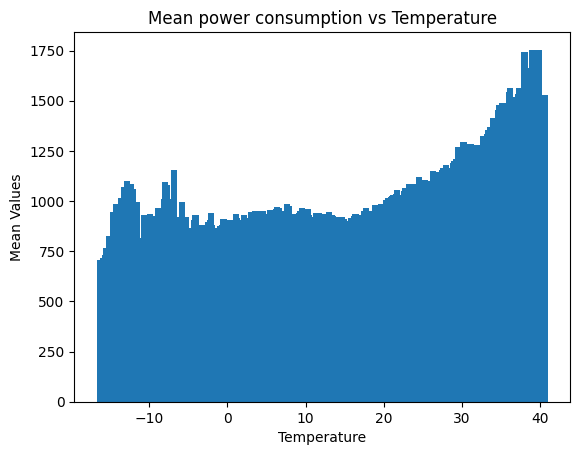

In [29]:
# plotting temperatue vs power consumption
import matplotlib.pyplot as plt

unique_temps = np.unique(concat_df['temp'])
# Plotting
plt.bar(unique_temps, concat_df.groupby('temp')['values'].mean())
plt.xlabel('Temperature')
plt.ylabel('Mean Values')
plt.title('Mean power consumption vs Temperature')
plt.show()

In [30]:
concat_df.columns

Index(['time', 'values', 'temp', 'up_of_month', 'down_of_month', 'sin_day',
       'cos_day', 'morning', 'afternoon', 'evening', 'weekend', 'time_slot',
       'peak_load', 'spring', 'summer', 'fall', 'winter', 'four_mean'],
      dtype='object')

In [32]:
# normalizing the value and mean columns
# Normalizing using the Standard Deviation Normalization method
concat_df_value_mean = concat_df["values"].mean()
concat_df_value_std = concat_df["values"].std()
concat_df.loc[:, "values"] = (concat_df["values"] - concat_df_value_mean) / concat_df_value_std

concat_df_four_mean_mean = concat_df["four_mean"].mean()
concat_df_four_mean_std = concat_df["four_mean"].std()
concat_df.loc[:, "four_mean"] = (concat_df["four_mean"] - concat_df_four_mean_mean) / concat_df_four_mean_std

# building Model


In [42]:
from sklearn.model_selection import KFold #Import the k-fold cross validation function in the machine learning library
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [40]:
concat_df.drop("time", axis=1 , inplace = True)

In [41]:
concat_df.columns

Index(['values', 'temp', 'up_of_month', 'down_of_month', 'sin_day', 'cos_day',
       'morning', 'afternoon', 'evening', 'weekend', 'time_slot', 'peak_load',
       'spring', 'summer', 'fall', 'winter', 'four_mean'],
      dtype='object')

In [51]:
concat_df.values

array([[-1.450910618416845, 6.7, 0, ..., 0, 0, -1.5027952194213867],
       [-1.7127212791750932, 6.1, 0, ..., 0, 0, -1.7740144729614258],
       [-1.874549505055152, 4.2, 0, ..., 0, 0, -1.9416581392288208],
       ...,
       [0.03801203797845493, 11.1, 0, ..., 0, 0, -0.2744734585285187],
       [-0.06340529605269914, 9.7, 0, ..., 0, 0, -0.07705871760845184],
       [-0.24428157533589384, 8.4, 0, ..., 0, 0, 0.022625023499131203]],
      dtype=object)

### hyper parametere tuning

In [60]:
# changed the "values" columns dtype to float
concat_df["values"] = pd.to_numeric(concat_df['values'], errors='coerce').astype(float)

In [62]:
from lightgbm.callback import early_stopping
# laoding dataset
y = concat_df['values']
X = concat_df.drop(['values'],axis=1)

# Define the objective function for Bayesian optimization
def lgb_cv(num_leaves, learning_rate, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'feature_fraction': max(min(feature_fraction, 1), 0),
        'bagging_fraction': max(min(bagging_fraction, 1), 0),
        'max_depth': int(max_depth),
        'lambda_l1': max(lambda_l1, 0),
        'lambda_l2': max(lambda_l2, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'metric': 'mse',  # Mean Squared Error
        'verbose': -1
    }

    # Perform k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

        model = lgb.train(params, lgb_train, num_boost_round=1000,
                          valid_sets=[lgb_val])

        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return -np.mean(rmse_scores)  # Negative because BayesianOptimization minimizes

# Define the search space for Bayesian optimization
pbounds = {
    'num_leaves': (24, 64),
    'learning_rate': (0.01, 0.3),
    'feature_fraction': (0.1, 0.9),
    'bagging_fraction': (0.1, 0.9),
    'max_depth': (5, 20),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'min_split_gain': (0.001, 0.1),
    'min_child_weight': (5, 50)
}

# Create the Bayesian optimization object
optimizer = BayesianOptimization(
    f=lgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2  # Adjust verbosity level as needed
)

# Perform Bayesian optimization
optimizer.maximize(
    init_points=10,
    n_iter=30,
)

# Get the best hyperparameters
best_params = optimizer.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.2376   | 0.3996    | 0.8606    | 3.66      | 2.993     | 0.05525   | 7.34      | 7.614     | 0.08675   | 48.04     |
| 2         | -0.2629   | 0.6665    | 0.1165    | 4.85      | 4.162     | 0.07158   | 7.727     | 13.25     | 0.03112   | 44.99     |
| 3         | -0.2455   | 0.4456    | 0.333     | 3.059     | 0.6975    | 0.09472   | 10.5      | 25.52     | 0.07873   | 31.99     |
| 4         | -0.2405   | 0.5114    | 0.5739    | 0.2323    | 3.038     | 0.05945   | 5.976     | 47.7      | 0.0966    | 56.34     |
| 5         | -0.2529   | 0.3437    | 0.1781    | 3.421     | 2.201     | 0.04539   | 12.43     | 6.547     | 0.09102   | 34.35     |
| 6         | -0.2462   | 0.63      | 0.3494    | 2.6       | 

In [63]:
best_params

{'bagging_fraction': 0.9,
 'feature_fraction': 0.9,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'learning_rate': 0.01,
 'max_depth': 20,
 'min_child_weight': 23.399737863355515,
 'min_split_gain': 0.001,
 'num_leaves': 64}

In [ ]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(best_params, lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_val],
                      )

    # Make predictions on the validation set
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # Calculate RMSE for the fold
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"Fold {fold + 1}, RMSE: {rmse}")
    rmse_scores.append(rmse)

# # Plot the RMSE for each fold
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o', linestyle='-', color='b')
# plt.title('RMSE for Each Fold')
# plt.xlabel('Fold')
# plt.ylabel('RMSE')
# plt.show()